In [28]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### To define the Headings of the Columns

In [29]:

Cols = ['ID', 'Target', 'Time to recurrence'] + \
        [f'x{i}' for i in range(30)] + ['dia', 'lym']
Cols_ = ', '.join(Cols)
Cols_, len(Cols)

('ID, Target, Time to recurrence, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, dia, lym',
 35)

### Converting the data file into csv for processing

In [30]:
with open(r'data\wpbc.data') as myfile:
    with open('xyz.csv', 'w') as f:
        f.write(Cols_)
        f.write('\n')
        for line in myfile.readlines():
            f.write(line)

### reading the Data using the Pandas library

In [31]:
Data = pd.read_csv('xyz.csv')
print(Data.shape)
Data

(198, 35)


,ID,Target,Time to recurrence,x0,x1,x2,x3,x4,x5,x6,...,x22,x23,x24,x25,x26,x27,x28,x29,dia,lym
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,...,139.70,1436.0,0.11950,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,...,184.60,2019.0,0.16220,0.6656,0.7119,0.26540,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.11890,0.12550,...,159.10,1949.0,0.11880,0.3449,0.3414,0.20320,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,...,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,...,152.20,1575.0,0.13740,0.2050,0.4000,0.16250,0.2364,0.07678,3.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,942640,N,10,22.52,21.92,146.90,1597.0,0.07592,0.09162,0.06862,...,162.10,1902.0,0.08191,0.1319,0.1056,0.09378,0.2061,0.05788,6.0,2
194,943471,N,8,15.44,31.18,101.00,740.4,0.09399,0.10620,0.13750,...,112.60,929.0,0.12720,0.2362,0.2975,0.12860,0.2914,0.08024,1.5,0
195,94547,N,12,17.17,29.19,110.00,915.3,0.08952,0.06655,0.06583,...,132.50,1295.0,0.12610,0.1572,0.2141,0.09520,0.3362,0.06033,3.7,0
196,947204,R,3,21.42,22.84,145.00,1440.0,0.10700,0.19390,0.23800,...,198.30,2375.0,0.14980,0.4379,0.5411,0.22150,0.2832,0.08981,3.0,?


##
Seperating first 130 Non-recurrent and first 37 Recurrent from the data to form Train Dataset

The Entry No #197 is also added to the Train set as required.

In [32]:
D1 = Data[Data[' Target'] == 'N']
D2 = Data[Data[' Target'] == 'R']
Train = pd.concat([D1[:130], D2[:37]]).append(Data.iloc[196])
Test = pd.concat([D1[130:], D2[37:]]).drop(196)
print(D1.shape, D2.shape, Train.shape, Test.shape)
Train.head(2)

(151, 35) (47, 35) (168, 35) (30, 35)


,ID,Target,Time to recurrence,x0,x1,x2,x3,x4,x5,x6,...,x22,x23,x24,x25,x26,x27,x28,x29,dia,lym
0,119513,N,31,18.02,27.60,117.5,1013.0,0.09489,0.1036,0.1086,...,139.7,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.8,1001.0,0.11840,0.2776,0.3001,...,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2




Imputing the datapoints where the data is not available or indicated as '?'

In [33]:
print('Before Imputation', (Train[' lym'] == '?').sum())
for col in Data.columns:
    impute = np.median(Train[col] != '?')
    Train[col] = Train[col].replace(['?'], impute)
    Test[col] = Test[col].replace(['?'], impute)
print('After Imputation', (Train[' lym'] == '?').sum())

Train.loc[Train[' lym']==impute]

Before Imputation 4
After Imputation 0


,ID,Target,Time to recurrence,x0,x1,x2,x3,x4,x5,x6,...,x22,x23,x24,x25,x26,x27,x28,x29,dia,lym
6,844359,N,60,18.98,19.61,124.40,1112.0,0.09087,0.1237,0.1213,...,152.6,1593.0,0.1144,0.3371,0.2990,0.1922,0.2726,0.09581,1.5,1.0
28,854253,N,12,16.74,21.59,110.10,869.5,0.09610,0.1336,0.1348,...,133.5,1229.0,0.1563,0.3835,0.5409,0.1813,0.4863,0.08633,1.5,1.0
85,877500,N,72,14.45,20.22,94.49,642.7,0.09872,0.1206,0.1180,...,117.9,1044.0,0.1552,0.4056,0.4967,0.1838,0.4753,0.10130,1.5,1.0
196,947204,R,3,21.42,22.84,145.00,1440.0,0.10700,0.1939,0.2380,...,198.3,2375.0,0.1498,0.4379,0.5411,0.2215,0.2832,0.08981,3.0,1.0


## Seperating  X (Datapoints) and Y (Targets)

In [34]:
Y_train = Train[' Target']
Y_test = Test[' Target']
X_Train = Train.drop(['ID', ' Target', ' Time to recurrence'], axis=1)
X_Test = Test.drop(['ID', ' Target', ' Time to recurrence'], axis=1)
X_Train.shape, X_Test.shape

((168, 32), (30, 32))

### Using Lable encoding to convert the probelm into binary {'0','1'} Classification. 

In [35]:
le = LabelEncoder()
le.fit(Y_train)
Y_Train = le.transform(Y_train)
Y_Test = le.transform(Y_test)


Gaussian Naive bayes with weighted probabilities as required in the Question.

In [36]:
p = Y_Train.sum()/len(Y_Train)
print(f'The value of p is {p} as the dataset is unbalanced')
clf = GaussianNB(priors=[1-p, p])
clf.fit(X_Train, Y_Train)

Y_train_pred = clf.predict_proba(X_Train)[:,1]
Y_test_pred = clf.predict_proba(X_Test)[:,1]

tr_fpr, tr_tpr, tr_thr = roc_curve(Y_Train, Y_train_pred)
tst_fpr, tst_tpr, te_thr = roc_curve(Y_Test, Y_test_pred)

The value of p is 0.2261904761904762 as the dataset is unbalanced


#### The 'roc_curve' of sklearn gives the fpr, tpr and thresold values for the given Ground truth and predicted values of Target

and 'auc' function gives area under curve


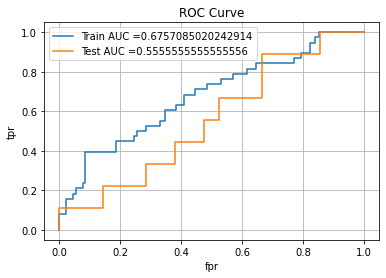

In [37]:
plt.plot(tr_fpr, tr_tpr, label="Train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(tst_fpr, tst_tpr, label="Test AUC ="+str(auc(tst_fpr, tst_tpr)))
plt.grid() ; plt.legend()
plt.xlabel("fpr") ;plt.ylabel("tpr") ;plt.title("ROC Curve")
plt.show()

### The 'confusion_matrix' of sklearn gives the confusion_matrix for the given ground truth and predictions

In [38]:
def predict_(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould: predictions.append(1)
        else:             predictions.append(0)
    return predictions

print("Train confusion matrix")
print(confusion_matrix(Y_Train, predict_(Y_train_pred, 0.5)))
print("-"*100)
print("Test confusion matrix")
print(confusion_matrix(Y_Test, predict_(Y_test_pred, 0.5)))

Train confusion matrix
[[98 32]
 [20 18]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[14  7]
 [ 6  3]]


### The 'precision_recall_fscore_support' of Sklearn gives the values as the name indicates. 

In [39]:
Tr = precision_recall_fscore_support(Y_Train, predict_(Y_train_pred, 0.5))
Te = precision_recall_fscore_support(Y_Test, predict_(Y_test_pred, 0.5))

print("for Train dataset")
print("-"*60)
print('Precisions for CLasses "N" and "R" are : ', Tr[0])
print('Recalls for CLasses "N" and "R" are : ', Tr[1])
print('Fscores for CLasses "N" and "R" are : ', Tr[2])

print("="*75)
print("for Test dataset")
print("-"*60)
print('Precisions for CLasses "N" and "R" are : ', Te[0])
print('Recalls for CLasses "N" and "R" are : ', Te[1])
print('Fscores for CLasses "N" and "R" are : ', Te[2])

for Train dataset
------------------------------------------------------------
Precisions for CLasses "N" and "R" are :  [0.83050847 0.36      ]
Recalls for CLasses "N" and "R" are :  [0.75384615 0.47368421]
Fscores for CLasses "N" and "R" are :  [0.79032258 0.40909091]
for Test dataset
------------------------------------------------------------
Precisions for CLasses "N" and "R" are :  [0.7 0.3]
Recalls for CLasses "N" and "R" are :  [0.66666667 0.33333333]
Fscores for CLasses "N" and "R" are :  [0.68292683 0.31578947]


#  Balancing the Dataset

In [40]:
#!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
oversample = SMOTE(sampling_strategy={'R': 90}) #the default k value for KNN is 5
X_Train, Y_train = oversample.fit_resample(X_Train, Y_train)

undersample = RandomUnderSampler(sampling_strategy={'N': 90})
X_Train, Y_train = undersample.fit_resample(X_Train, Y_train)

X_Train.shape, Y_train.shape

((180, 32), (180,))

In [41]:
le = LabelEncoder()
le.fit(Y_train)
Y_Train = le.transform(Y_train)
Y_Test = le.transform(Y_test)

In [42]:
p = Y_Train.sum()/len(Y_Train)
print(f'The value of p is {p} as the dataset is balanced')
clf = GaussianNB(priors=[1-p, p])
clf.fit(X_Train, Y_Train)

Y_train_pred = clf.predict_proba(X_Train)[:,1]
Y_test_pred = clf.predict_proba(X_Test)[:,1]

tr_fpr, tr_tpr, tr_thr = roc_curve(Y_Train, Y_train_pred)
tst_fpr, tst_tpr, te_thr = roc_curve(Y_Test, Y_test_pred)

The value of p is 0.5 as the dataset is balanced


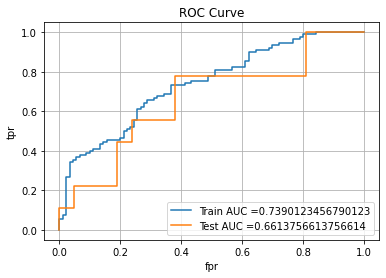

In [43]:
plt.plot(tr_fpr, tr_tpr, label="Train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(tst_fpr, tst_tpr, label="Test AUC ="+str(auc(tst_fpr, tst_tpr)))
plt.grid() ; plt.legend()
plt.xlabel("fpr") ;plt.ylabel("tpr") ;plt.title("ROC Curve")
plt.show()

In [44]:
def predict_(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould: predictions.append(1)
        else:             predictions.append(0)
    return predictions

print("Train confusion matrix")
print(confusion_matrix(Y_Train, predict_(Y_train_pred, 0.5)))
print("-"*100)
print("Test confusion matrix")
print(confusion_matrix(Y_Test, predict_(Y_test_pred, 0.5)))

Train confusion matrix
[[61 29]
 [30 60]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[16  5]
 [ 4  5]]


In [45]:
Tr = precision_recall_fscore_support(Y_Train, predict_(Y_train_pred, 0.5))
Te = precision_recall_fscore_support(Y_Test, predict_(Y_test_pred, 0.5))

print("for Train dataset")
print("-"*60)
print('Precisions for CLasses "N" and "R" are : ', Tr[0])
print('Recalls for CLasses "N" and "R" are : ', Tr[1])
print('Fscores for CLasses "N" and "R" are : ', Tr[2])

print("="*75)
print("for Test dataset")
print("-"*60)
print('Precisions for CLasses "N" and "R" are : ', Te[0])
print('Recalls for CLasses "N" and "R" are : ', Te[1])
print('Fscores for CLasses "N" and "R" are : ', Te[2])

for Train dataset
------------------------------------------------------------
Precisions for CLasses "N" and "R" are :  [0.67032967 0.6741573 ]
Recalls for CLasses "N" and "R" are :  [0.67777778 0.66666667]
Fscores for CLasses "N" and "R" are :  [0.67403315 0.67039106]
for Test dataset
------------------------------------------------------------
Precisions for CLasses "N" and "R" are :  [0.8 0.5]
Recalls for CLasses "N" and "R" are :  [0.76190476 0.55555556]
Fscores for CLasses "N" and "R" are :  [0.7804878  0.52631579]


# Observation



*   The Test-AUC score improved from 0.555 to 0.66
*   The Test- Precision  improved from [0.7 0.3] to [0.8 0.5]
* The Test- Recall  changed from [0.66666667 0.33333333] to [0.7619 0.55556]
* The Test- FScores  chenged from [0.68292683 0.31578947] to [0.7804 0.5263]


as observed, there were some minor improvements after using SMOTE